In [1]:
import glob, string, string
from PIL import Image

import torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision as tv
import torchvision.transforms.v2 as T
TFN = T.functional
from einops import rearrange

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from models.ocrnet import OCRNet
from util import EMA

In [3]:
import yaml, pprint
with open('charlevel2.yaml') as f:
    cfg = yaml.load(f, yaml.Loader)['config']
pprint.pp(cfg)

{'backbone': {'ch_in': 1, 'n_layers': 4, 'init_filters': 8, 'ch_out': 8},
 'encoder': {'ch_in': 8,
             'n_ctx': 16,
             'patch_size': [2, 2],
             'n_blocks': 4,
             'n_embd': 192,
             'n_heads': 4},
 'decoder': {'n_ctx': 34,
             'n_vocab': 100,
             'n_blocks': 4,
             'n_embd': 192,
             'n_heads': 4}}


In [4]:
n_vocab = cfg['decoder']['n_vocab']
n_enc_ctx = cfg['encoder']['n_ctx']
n_dec_ctx = cfg['decoder']['n_ctx']

In [5]:
vocab = string.printable
stoi = { ch:i for i, ch in enumerate(vocab) }
itos = { i:ch for i, ch in enumerate(vocab) }
bos, bos_id = '\r', stoi['\r']
eos, eos_id = '\n', stoi['\n']
assert len(vocab) == n_vocab

In [6]:
vocab

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [8]:
def encode(s):
    return torch.tensor([stoi[ch] for ch in s])

def decode(x):
    x = x.squeeze()
    return ''.join(itos[i] for i in x.tolist())

In [9]:
class SynthData(Dataset):
    def __init__(self, folders, filter=None, transform=None):
        super().__init__()
        self.folders = folders
        self.data = []
        for folder in folders:
            with open(folder + '/labels.txt') as f:
                for entry in f:
                    fname, text = entry.strip().split(maxsplit=1)
                    fpath = folder + '/' + fname
                    if filter and not filter(fpath, text):
                        continue
                    self.data.append((fpath, text))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        im_path, text = self.data[idx]
        im = Image.open(im_path)
        if self.transform:
            return self.transform(im, text)
        return im, text

In [10]:
def data_filter(fpath, text):
    if len(text) + 2 > n_dec_ctx:
        return False
    if any(c not in string.printable for c in text):
        return False
    return Image.open(fpath).size[0] < 512

In [11]:
transforms = T.Compose([
    T.RandomAffine(degrees=0, scale=(0.95, 1.05), translate=(0.01, 0.01)),
])
def transform(im, text=None):
    im = TFN.to_dtype(TFN.to_image(im)) / 255
    im = 1 - im
    ar = im.size(-1) / im.size(-2)
    im = TFN.resize(im, (32, int(ar * 32)))
    dx = 512 - im.size(-1)
    im = TFN.pad(im, (0, 0, dx, 0), fill=0)

    if text is None:
        return im, None, None
    
    n_pad = n_dec_ctx - len(text) - 1
    toks = encode(bos + text + eos*n_pad)
    x_ctx = toks[:-1]
    target = toks[1:]
    
    return transforms(im), x_ctx, target

In [12]:
def collate_fn(data):
    n = len(data)
    x_im = torch.vstack([data[i][0] for i in range(n)])[:, None, :, :]
    x_ctx = torch.vstack([data[i][1] for i in range(n)])
    target = torch.vstack([data[i][2] for i in range(n)])
    return (x_im, x_ctx), target

In [13]:
ds = SynthData(glob.glob('data/*'), data_filter, transform)

In [14]:
len(ds)

339529

In [15]:
dl = torch.utils.data.DataLoader(ds, 512, num_workers=4, shuffle=True, collate_fn=collate_fn)

In [16]:
torch.manual_seed(42)
net = OCRNet(cfg).cuda()
print(sum(p.numel() for p in net.parameters()))

4476194


In [17]:
net.load_state_dict(torch.load('ckpts/charlevel-tiny.pt'))

<All keys matched successfully>

In [ ]:
net.backbone.load_state_dict(torch.load('ckpts/cnn2.pt'))

In [18]:
opt = net.configure_optimizers(device='cuda', lr=1e-3)

In [ ]:
for p in net.backbone.parameters():
    p.requires_grad = False

In [19]:
scaler = torch.cuda.amp.GradScaler()
torch.set_float32_matmul_precision('high')

In [23]:
for g in opt.param_groups:
    g['lr'] = 3e-5

In [21]:
ema_loss = EMA()

In [24]:
net.train()
step, grad_acc_steps = 0, 1
for _ in range(10):
    for (x_im, x_ctx), target in (t := tqdm(dl)):
        x_im, x_ctx, target = x_im.cuda(), x_ctx.cuda(), target.cuda()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits, loss = net(x_im, x_ctx, target)
            loss /= grad_acc_steps
    
        with torch.no_grad():
            acc = torch.mean(logits.argmax(-1) == target, dtype=torch.float)
        
        scaler.scale(loss).backward()
        step += 1
        if step % grad_acc_steps == 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)
    
        
        ema_loss.update(loss.item() * grad_acc_steps)
        t.set_description(f'loss {ema_loss.value:.4f} acc {acc.item():.4f}')

  0%|          | 0/664 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
torch.save(net.state_dict(), 'ckpts/tinyv2.pt')

In [26]:
net.eval()
with torch.inference_mode():
    for (x_im, x_ctx), target in (t := tqdm(dl)):
        x_im, x_ctx, target = x_im.cuda(), x_ctx.cuda(), target.cuda()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            preds, loss = net(x_im, x_ctx, target)
        break

  0%|          | 0/664 [00:00<?, ?it/s]

In [27]:
preds.shape, target.shape

(torch.Size([512, 33, 100]), torch.Size([512, 33]))

In [28]:
preds = preds.argmax(-1).cpu()

In [29]:
decode(preds[1])

'horee-bou transmutations\n\n\n\n\n\n\n\n\n'

In [30]:
decode(target[1])

'horse-box transmutations\n\n\n\n\n\n\n\n\n'

In [31]:
@torch.inference_mode()
def predict(x_im):
    net.eval()
    if x_im.ndim != 4:
        x_im = x_im.view(-1, 1, x_im.size(-2), x_im.size(-1))
    x_enc = net.encoder(net.backbone(x_im.cuda()))
    x_ctx = torch.tensor([bos_id], device='cuda')
    while True:
        logits = net.decoder(x_ctx[None], x_enc)
        tok_idx = logits[:, -1, :].argmax(-1)
        if tok_idx == eos_id or len(x_ctx) >= n_dec_ctx:
            break
        x_ctx = torch.cat((x_ctx, tok_idx))

    return decode(x_ctx)[1:]

In [32]:
x_ctx[0]

tensor([97, 87, 83, 85, 94, 26, 19, 23, 84, 90, 66, 74,  5, 84, 96, 96, 96, 96,
        96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96],
       device='cuda:0')

In [33]:
predict(x_im[[4]])

'panmixy'

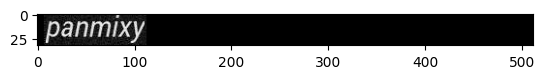

In [34]:
plt.imshow(x_im[4].cpu().squeeze(), cmap='gray')

In [35]:
def impreprocess(im):
    return transform(im)[0]

In [36]:
import glob
from PIL import Image
crop_files = sorted(glob.glob('crops/*.jpg'))
print(crop_files)

['crops/0.jpg', 'crops/1.jpg', 'crops/10.jpg', 'crops/11.jpg', 'crops/12.jpg', 'crops/13.jpg', 'crops/14.jpg', 'crops/15.jpg', 'crops/16.jpg', 'crops/17.jpg', 'crops/18.jpg', 'crops/2.jpg', 'crops/3.jpg', 'crops/4.jpg', 'crops/5.jpg', 'crops/6.jpg', 'crops/7.jpg', 'crops/8.jpg', 'crops/9.jpg']


Java.


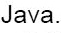

In [42]:
im = Image.open(crop_files[4])
print(predict(impreprocess(im)).strip())
im

In [41]:
x_im = impreprocess(im)

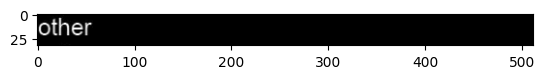

In [42]:
plt.imshow(x_im.squeeze(), cmap='gray')

In [43]:
predict(x_im)

'other'